<a href="https://colab.research.google.com/github/chibuezedev/MMTD/blob/main/MMTD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import random
from tqdm import tqdm


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from transformers import BertModel, BertTokenizer, RobertaModel, RobertaTokenizer, XLMRobertaTokenizer, XLMRobertaModel, XLMRobertaTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns


# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   labels   5572 non-null   object
 1   text     5572 non-null   object
 2   text_hi  5572 non-null   object
 3   text_de  5572 non-null   object
 4   text_fr  5572 non-null   object
dtypes: object(5)
memory usage: 217.8+ KB
None
  labels                                               text  \
0    ham  Go until jurong point, crazy.. Available only ...   
1    ham                      Ok lar... Joking wif u oni...   
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...   
3    ham  U dun say so early hor... U c already then say...   
4    ham  Nah I don't think he goes to usf, he lives aro...   

                                             text_hi  \
0  Dakag बिंदु तक जाओ, पागल. केवल Bag Non महान वि...   
1                         ओके लामर.... if if uue पर.   
2  Fktatatat 21 मई को प्राप्त करने के लिए

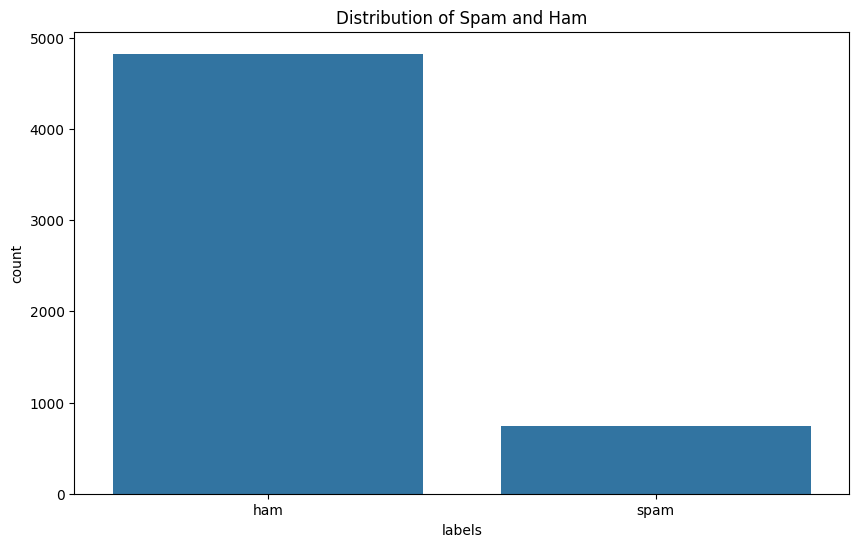

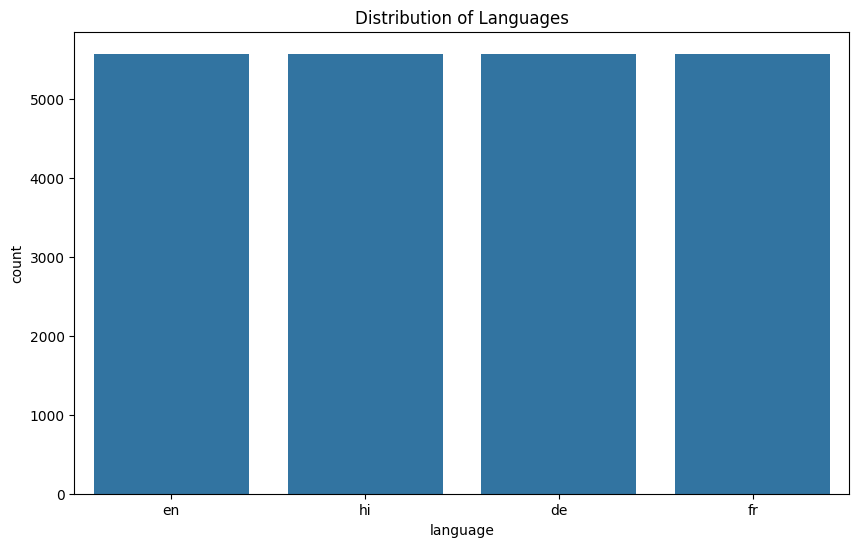

Training set shape: (17830, 3)
Test set shape: (4458, 3)


In [ ]:
# Load the dataset
df = pd.read_csv('data-en-hi-de-fr.csv')

# Display basic information
print(df.info())
print(df.head())

# Check class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='labels', data=df)
plt.title('Distribution of Spam and Ham')
plt.show()

# Preprocess the dataset
# Ensure 'labels' column is binary (0 for ham, 1 for spam)
df['labels'] = df['labels'].map({'ham': 0, 'spam': 1})

# Restructure the dataframe to have a single 'text' column and a 'language' column
languages = ['en', 'hi', 'de', 'fr']
new_rows = []

for _, row in df.iterrows():
    for lang in languages:
        if lang == 'en':
            text_col = 'text'
        else:
            text_col = f'text_{lang}'
        new_rows.append({
            'label': row['labels'],
            'text': row[text_col],
            'language': lang
        })

new_df = pd.DataFrame(new_rows)

# Check language distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='language', data=new_df)
plt.title('Distribution of Languages')
plt.show()

# Split the dataset into train and test sets
train_df, test_df = train_test_split(new_df, test_size=0.2, stratify=new_df[['label', 'language']], random_state=42)

print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")


In [ ]:
import random
# Now, let's add an image component
spam_images = os.listdir('spam_images')
ham_images = os.listdir('ham_images')

def assign_image(row):
    if row['label'] == 1:  # spam
        return f"spam_images/{random.choice(spam_images)}"
    else:  # ham
        return f"ham_images/{random.choice(ham_images)}"

# Add image paths to both train and test dataframes
train_df['image_path'] = train_df.apply(assign_image, axis=1)
test_df['image_path'] = test_df.apply(assign_image, axis=1)

# Save the preprocessed datasets
train_df.to_csv('train_multilingual_multimodal_spam.csv', index=False)
test_df.to_csv('test_multilingual_multimodal_spam.csv', index=False)

print("Preprocessing complete. Datasets saved as CSV files.")

# Display sample of the final dataset
print(train_df.head())

Preprocessing complete. Datasets saved as CSV files.
       label                                               text language  \
7466       0  Rufen Sie die Nummer an, die nach Vereinbarung...       de   
8041       0  मैं इस के माध्यम से आगे नहीं बढ़ सकता. यह कभी ...       hi   
14135      0  En fait, mon mobile est plein de msg. Et je fa...       fr   
3261       1  Smamawawavon520 पर Smaka Pyr. 2 को फिर से करने...       hi   
11972      0          K.i did't see you.:)k:)where are you now?       en   

                                      image_path  
7466   ham_images/zzz_412523576_045b3e623c_m.jpg  
8041       ham_images/zzz_82495_d51590f351_m.jpg  
14135      ham_images/zzz_65443_8037b212d7_m.jpg  
3261                  spam_images/D2gfNHPSLU.jpg  
11972       ham_images/zzz_7359_449584eb9a_m.jpg  


In [ ]:
# Print some statistics
print("\nDataset Statistics:")
print(f"Total samples: {len(train_df) + len(test_df)}")
print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")
print("\nLabel distribution in training set:")
print(train_df['label'].value_counts(normalize=True))
print("\nLanguage distribution in training set:")
print(train_df['language'].value_counts(normalize=True))


Dataset Statistics:
Total samples: 22288
Training samples: 17830
Testing samples: 4458

Label distribution in training set:
label
0    0.865956
1    0.134044
Name: proportion, dtype: float64

Language distribution in training set:
language
hi    0.250028
en    0.250028
de    0.249972
fr    0.249972
Name: proportion, dtype: float64


In [ ]:
from tqdm import tqdm
# Check image availability
print("\nChecking image availability...")
missing_images = 0
for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
    if not os.path.exists(row['image_path']):
        missing_images += 1
print(f"Number of missing images in training set: {missing_images}")

missing_images = 0
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    if not os.path.exists(row['image_path']):
        missing_images += 1
print(f"Number of missing images in test set: {missing_images}")


Checking image availability...


100%|██████████| 17830/17830 [00:01<00:00, 16116.91it/s]


Number of missing images in training set: 0


100%|██████████| 4458/4458 [00:00<00:00, 13736.36it/s]

Number of missing images in test set: 0


In [ ]:

# Load the CSV files
train_df = pd.read_csv('train_multilingual_multimodal_spam.csv')
test_df = pd.read_csv('test_multilingual_multimodal_spam.csv')

# Print basic information
print("Train DataFrame:")
print(train_df.info())
print("\nTest DataFrame:")
print(test_df.info())

# Display a few rows
print("\nSample rows from train_df:")
print(train_df.head())

Train DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17830 entries, 0 to 17829
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       17830 non-null  int64 
 1   text        17830 non-null  object
 2   language    17830 non-null  object
 3   image_path  17830 non-null  object
dtypes: int64(1), object(3)
memory usage: 557.3+ KB
None

Test DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4458 entries, 0 to 4457
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       4458 non-null   int64 
 1   text        4458 non-null   object
 2   language    4458 non-null   object
 3   image_path  4458 non-null   object
dtypes: int64(1), object(3)
memory usage: 139.4+ KB
None

Sample rows from train_df:
   label                                               text language  \
0      0  Rufen Sie die Nummer an, die nach Vereinbarung..

In [ ]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from transformers import XLMRobertaTokenizer
import torchvision.transforms as transforms
import pandas as pd

class SpamDataset(torch.utils.data.Dataset):
    def __init__(self, texts, image_paths, labels, languages, tokenizer, transform):
        self.texts = texts
        self.image_paths = image_paths
        self.labels = labels
        self.languages = languages
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = str(self.texts[idx])  # Ensure text is a string
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        language = self.languages[idx]

        # Tokenize text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Load and transform image
        try:
            image = Image.open(image_path).convert('RGB')
            image = self.transform(image)
        except Exception as e:
            print(f"Error loading image {image_path}: {str(e)}")
            # Use a blank image as a fallback
            image = torch.zeros(3, 224, 224)

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'image': image,
            'label': torch.tensor(label, dtype=torch.long),
            'language': language

        }




In [ ]:
import pandas as pd
import os


def load_and_preprocess_data(csv_path, batch_size=32):
    # Load data from CSV
    df = pd.read_csv(csv_path)
    print(f"Loaded {len(df)} rows from {csv_path}")

    # Prepend the base directory to the image paths
    # base_dir = 'sample_data'  # Adjust this if your directory structure is different
    # df['image_path'] = df['image_path'].apply(lambda x: os.path.join(base_dir, x))
    # Get the current working directory
    base_dir = os.getcwd()

    # Prepend the base directory to the image paths
    df['image_path'] = df['image_path'].apply(lambda x: os.path.join(base_dir, x))

    # Check if image files exist
    existing_images = df[df['image_path'].apply(os.path.exists)]
    missing_images = len(df) - len(existing_images)
    print(f"Found {len(existing_images)} images. {missing_images} images are missing.")

    # Print a few example paths
    print("Example image paths:")
    print(df['image_path'].head())

    # Define transforms for images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
    print("Tokenizer loaded")

    try:
        train_dataset = SpamDataset(
            train_df['text'].tolist(),
            train_df['image_path'].tolist(),
            train_df['label'].tolist(),
            train_df['language'].tolist(),
            tokenizer,
            transform
        )
        print("Train dataset created successfully")

        test_dataset = SpamDataset(
            test_df['text'].tolist(),
            test_df['image_path'].tolist(),
            test_df['label'].tolist(),
            test_df['language'].tolist(),
            tokenizer,
            transform
        )
        print("Test dataset created successfully")

        # Create DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        return train_loader, test_loader
    except Exception as e:
        print(f"Error creating datasets: {str(e)}")
        raise

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import XLMRobertaModel


class FeatureExtractor(nn.Module):
    print("Class definition reached")

    def __init__(self):
        print("Initializing FeatureExtractor")
        super(FeatureExtractor, self).__init__()

        print("Loading ResNet152")
        self.image_encoder = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
        self.image_encoder.fc = nn.Identity()

        print("Loading XLM-RoBERTa")
        self.text_encoder = XLMRobertaModel.from_pretrained('xlm-roberta-base')

        print("FeatureExtractor initialized")

    def forward(self, images, input_ids, attention_mask):
        print("Forward method called")
        image_features = self.image_encoder(images)
        text_outputs = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.last_hidden_state[:, 0, :]
        print(f"Image features shape: {image_features.shape}")
        print(f"Text features shape: {text_features.shape}")
        return image_features, text_features

print("Creating FeatureExtractor instance")
feature_extractor = FeatureExtractor()
print("FeatureExtractor instance created")

Class definition reached
Creating FeatureExtractor instance
Initializing FeatureExtractor
Loading ResNet152
Loading XLM-RoBERTa


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


FeatureExtractor initialized
FeatureExtractor instance created


In [ ]:
# 3. Model Selection

class AdvancedMMTD(nn.Module):
    def __init__(self, num_classes=2):
        super(AdvancedMMTD, self).__init__()

        self.feature_extractor = FeatureExtractor()
        print("Feature extractor loaded")
        # Multimodal Fusion Module
        self.fusion = nn.Sequential(
            nn.Linear(2048 + 768, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

        # Attention mechanism
        self.attention = nn.MultiheadAttention(embed_dim=2048 + 768, num_heads=8)

    def forward(self, images, input_ids, attention_mask):
        # Extract features
        image_features, text_features = self.feature_extractor(images, input_ids, attention_mask)

        # Concatenate features
        combined_features = torch.cat((image_features, text_features), dim=1)

        # Apply attention mechanism
        attended_features, _ = self.attention(combined_features.unsqueeze(0), combined_features.unsqueeze(0), combined_features.unsqueeze(0))
        attended_features = attended_features.squeeze(0)

        # Fusion and classification
        output = self.fusion(attended_features)

        return output


In [ ]:

# 4. Training Process

def train_model(model, train_loader, val_loader, num_epochs, lr, device, accumulation_steps=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for i, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss = loss / accumulation_steps  # Normalize the loss
            loss.backward()

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            train_loss += loss.item() * accumulation_steps

        # Calculate average training loss
        train_loss /= len(train_loader)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                images = batch['image'].to(device)
                labels = batch['label'].to(device)

                outputs = model(images, input_ids, attention_mask)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy
        val_loss /= len(val_loader)
        val_accuracy = val_correct / val_total

        # Print epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Val Accuracy: {val_accuracy:.4f}')

        # Learning rate scheduler step
        scheduler.step(val_loss)

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Best model saved with validation loss: {best_val_loss:.4f}')

    print('Training completed.')
    return model

In [ ]:


# 5. Model Evaluation

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images, input_ids, attention_mask)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [ ]:
import torch
from torch.utils.data import DataLoader

# Main execution
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Reduce batch size
    batch_size = 4  # Start with a small batch size
    train_loader, test_loader = load_and_preprocess_data('train_multilingual_multimodal_spam.csv', batch_size=batch_size)
    print("Data loaded and preprocessed")

    # Use a smaller model for testing
    model = AdvancedMMTD(num_classes=2).to(device)
    print("Model initialized")

    # Reduce number of epochs for testing
    num_epochs = 5
    learning_rate = 2e-5

    # Implement gradient accumulation
    accumulation_steps = 8  # Accumulate gradients over 8 mini-batches
    trained_model = train_model(model, train_loader, test_loader, num_epochs=num_epochs,
                                lr=learning_rate, device=device, accumulation_steps=accumulation_steps)
    print("Model training completed")

    # Evaluate model
    print("Evaluating model...")
    evaluate_model(trained_model, test_loader, device)
    print("Model evaluation completed")

    # Test model
    print("Testing model...")
    test_predictions = test_model(trained_model, test_loader, device)
    print("Model testing completed. Predictions are stored in 'test_predictions'.")

    # Save the trained model
    print("Saving model...")
    torch.save(trained_model.state_dict(), 'trained_spam_model.pth')
    print("Trained model saved to 'trained_spam_model.pth'")

    # Optional: Save test predictions to a file
    import pandas as pd
    test_df = pd.read_csv('test_multilingual_multimodal_spam.csv')
    test_df['predicted_label'] = test_predictions
    test_df.to_csv('test_results_with_predictions.csv', index=False)
    print("Test results with predictions saved to 'test_results_with_predictions.csv'")

    print("All processes completed successfully!")

Using device: cpu
Loaded 17830 rows from train_multilingual_multimodal_spam.csv
Found 17830 images. 0 images are missing.
Example image paths:
0    /content/ham_images/zzz_412523576_045b3e623c_m...
1       /content/ham_images/zzz_82495_d51590f351_m.jpg
2       /content/ham_images/zzz_65443_8037b212d7_m.jpg
3                  /content/spam_images/D2gfNHPSLU.jpg
4        /content/ham_images/zzz_7359_449584eb9a_m.jpg
Name: image_path, dtype: object


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Tokenizer loaded
Train dataset created successfully
Test dataset created successfully
Data loaded and preprocessed
Initializing FeatureExtractor
Loading ResNet152
Loading XLM-RoBERTa
FeatureExtractor initialized
Feature extractor loaded
Model initialized
Forward method called
Image features shape: torch.Size([4, 2048])
Text features shape: torch.Size([4, 768])
Forward method called
Image features shape: torch.Size([4, 2048])
Text features shape: torch.Size([4, 768])
Forward method called
Image features shape: torch.Size([4, 2048])
Text features shape: torch.Size([4, 768])
Forward method called
Image features shape: torch.Size([4, 2048])
Text features shape: torch.Size([4, 768])
Forward method called
Image features shape: torch.Size([4, 2048])
Text features shape: torch.Size([4, 768])
Forward method called
Image features shape: torch.Size([4, 2048])
Text features shape: torch.Size([4, 768])
Forward method called
Image features shape: torch.Size([4, 2048])
Text features shape: torch.Size

In [ ]:

# 6. Model Testing

def test_model(model, test_loader, device):
    model.eval()
    all_preds = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)

            outputs = model(images, input_ids, attention_mask)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())

    return all_preds
